<a href="https://colab.research.google.com/github/binliu0630/transformers/blob/master/Transformer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Started

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print(f'Found GPU at: {device_name}')
else:
  raise SystemError('GPU device not available')

Found GPU at: /device:GPU:0


In [0]:
import torch

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(f'There are {torch.cuda.device_count()} GPU(s) available')
  print(f'We will use the GPU: {torch.cuda.get_device_name()} with the capacity of: {torch.cuda.get_device_capability()}')
else:
  device = torch.device('cpu')
  print(f'No GPU is available, using CPU instead.')
  


There are 1 GPU(s) available
We will use the GPU: Tesla T4 with the capacity of: (7, 5)


In [3]:
!pip install transformers

     |████████████████████████████████| 501kB 9.3MB/s 
     |████████████████████████████████| 1.0MB 67.6MB/s 
     |████████████████████████████████| 3.7MB 71.7MB/s 
     |████████████████████████████████| 870kB 63.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=6bc36451461b6aaecfdd7b36b93095321ce1f9bcb7ab25045fb1c4b194b3ebf0
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8e4cd10d3a8ed69142995da2185b3ea73b9c6d5add3431e698b385d12d55d8bc
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
import os
import pandas as pd

## Data Prep

In [0]:
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

In [7]:
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [8]:
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.sample(10)

,sentence_source,label,label_notes,sentence
3934,ks08,1,NaN,John disappeared.
2326,l-93,1,NaN,The judge offered a prize to the winner.
7562,sks13,1,NaN,John's mother likes him.
6659,m_02,1,NaN,The cat trotted into the kitchen.
4103,ks08,0,*,You should attempt answering every question.
8541,ad03,1,NaN,Where has he put the cake?
5926,c_13,0,*,placed the flute on the table.
6240,c_13,0,*,It is reluctant that Jean left.
25,gj04,0,*,Harry coughed himself.
8291,ad03,0,*,We wanted to ate cake


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551 entries, 0 to 8550
Data columns (total 4 columns):
sentence_source    8551 non-null object
label              8551 non-null int64
label_notes        2527 non-null object
sentence           8551 non-null object
dtypes: int64(1), object(3)
memory usage: 267.3+ KB


In [10]:
df[df['label']==0].sample(5).loc[:, ['sentence', 'label']]

,sentence,label
3160,My eyes are itching my brother.,0
974,The writers so believed the boy.,0
2574,I lifted him up the books.,0
7220,It is arrive tomorrow that Mary will.,0
5378,Enough Sally eats caviar.,0


In [0]:
sentences = df['sentence'].values
labels = df['label'].values

## Tokenization & Input formatting

In [0]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [0]:
MODEL_NAME = 'roberta-base'
MODEL_NAME = "bert-base-uncased"
MODEL_NAME = 'albert-base-v1'
MODEL_NAME = 'flaubert-small-cased'
BATCH_SIZE = 32

In [136]:
tokenzier = AutoTokenizer.from_pretrained(MODEL_NAME)

In [0]:
token = tokenzier.batch_encode_plus(sentences, max_length=64, pad_to_max_length=True)

In [138]:
token.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [0]:
input_ids = token['input_ids']
attention_mask = token['attention_mask']

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_mask, labels, random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_inputs)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

In [0]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_inputs)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

## Model Training

In [144]:
config=AutoConfig.from_pretrained(MODEL_NAME, num_labels=2)
config

FlaubertConfig {
  "amp": 1,
  "architectures": [
    "FlaubertWithLMHeadModel"
  ],
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "bos_token_id": null,
  "bptt": 512,
  "causal": false,
  "clip_grad_norm": 5,
  "do_sample": false,
  "dropout": 0.1,
  "emb_dim": 512,
  "embed_init_std": 0.02209708691207961,
  "encoder_only": true,
  "end_n_top": 5,
  "eos_index": 1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "fp16": true,
  "gelu_activation": true,
  "group_by_size": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "id2lang": {
    "0": "fr"
  },
  "init_std": 0.02,
  "is_decoder": false,
  "is_encoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "lang2id": {
    "fr": 0
  },
  "lang_id": 0,
  "langs": [
    "fr"
  ],
  "layer_norm_eps": 1e-06,
  "layerdrop": 0.2,
  "length_penalty": 1.0,
  "lg_sampling_factor": -1,
  "lgs": "fr",
  "mask_index": 5,
  "mask_token_id": 0,
  "max_batch_size": 0,
  "max_length": 20,
  "m

In [145]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model.cuda();

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [150]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:04.
  Batch    80  of    241.    Elapsed: 0:00:07.
  Batch   120  of    241.    Elapsed: 0:00:11.
  Batch   160  of    241.    Elapsed: 0:00:14.
  Batch   200  of    241.    Elapsed: 0:00:18.
  Batch   240  of    241.    Elapsed: 0:00:21.

  Average training loss: 0.65
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.69
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:04.
  Batch    80  of    241.    Elapsed: 0:00:07.
  Batch   120  of    241.    Elapsed: 0:00:11.
  Batch   160  of    241.    Elapsed: 0:00:14.
  Batch   200  of    241.    Elapsed: 0:00:18.
  Batch   240  of    241.    Elapsed: 0:00:21.

  Average training loss: 0.62
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.66
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:03.
  

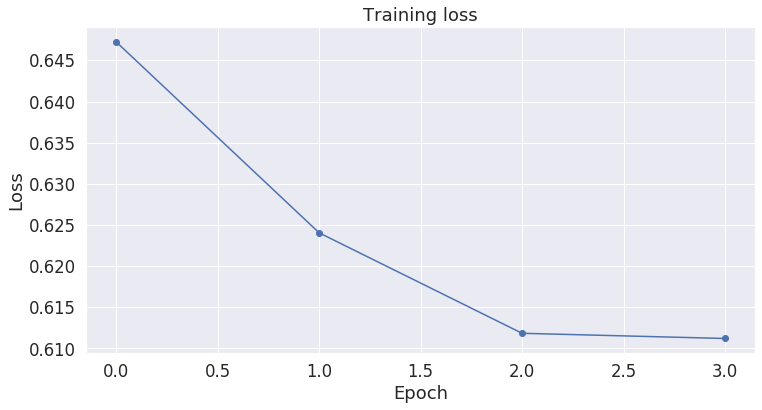

In [151]:
# flaubert-small-cased
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

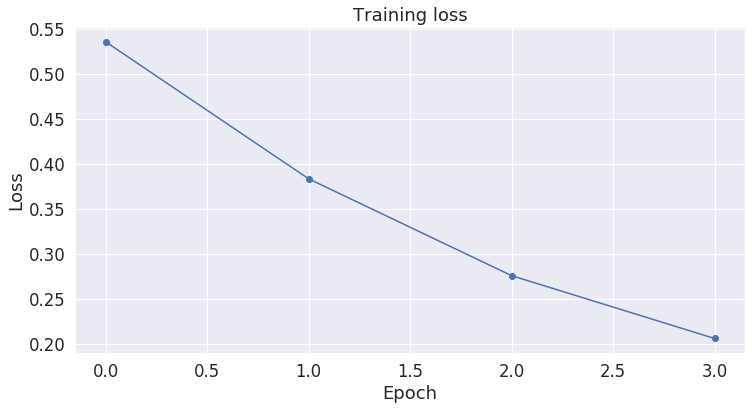

In [134]:
# 	albert-base-v1
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

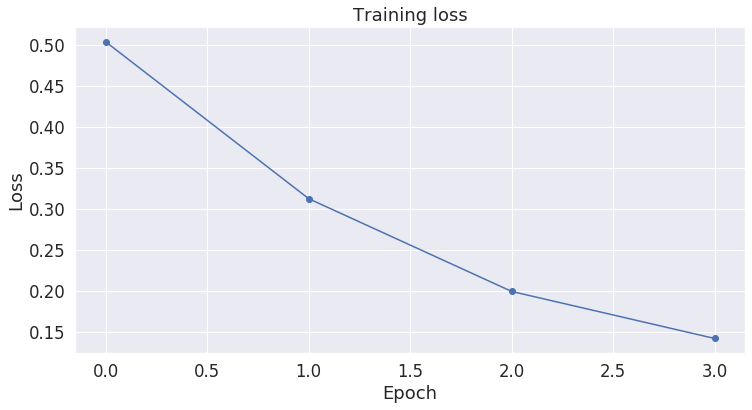

In [95]:
# Bert
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

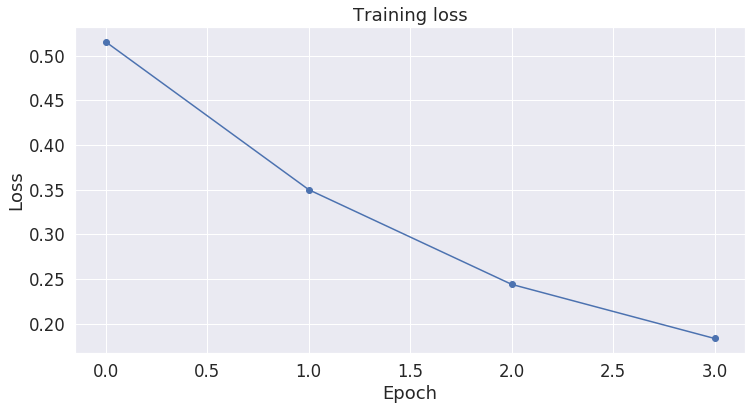

In [68]:
# Roberta
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()